In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

sns.set_style("whitegrid")
sns.set_context("paper", font_scale=1)

In [2]:
races = pd.read_csv('data/races.csv')
races = races.set_index("raceId")
results = pd.read_csv('data/results.csv')
results = results.set_index("resultId")
lapTimes = pd.read_csv('data/lap_times.csv')
lapTimes = lapTimes.set_index("raceId")

drivers = pd.read_csv('data/drivers.csv')
drivers = drivers.set_index("driverId")
constructors = pd.read_csv('data/constructors.csv')
constructors = constructors.set_index("constructorId")
circuits = pd.read_csv('data/circuits.csv')
circuits = circuits.set_index("circuitId")

In [3]:
def lookupCols(df, lookup_df, key_col, cols):
    return df.join(lookup_df[cols], on=key_col)

def filterYears(df, minYear=2022, maxYear=2024):
    return df[(df['year'] >= minYear) & (df['year'] <= maxYear)]

Constructor colours (2010-2024)

In [4]:
results_year = lookupCols(results, races, 'raceId', ['year'])
results_modern = filterYears(results_year, 2010, 2024)
constructors_modern = lookupCols(results_modern, constructors, 'constructorId', ['name'])['name'].unique()

constructors_modern

array(['Ferrari', 'McLaren', 'Red Bull', 'Mercedes', 'Force India',
       'Williams', 'Renault', 'Toro Rosso', 'Lotus', 'Sauber', 'HRT',
       'Virgin', 'Lotus F1', 'Marussia', 'Caterham', 'Manor Marussia',
       'Haas F1 Team', 'Alfa Romeo', 'Racing Point', 'AlphaTauri',
       'Aston Martin', 'Alpine F1 Team', 'RB F1 Team'], dtype=object)

In [5]:
constructor_palette = {
    "Ferrari": "#DC0000",            # Rosso Corsa
    "McLaren": "#FF8700",            # Papaya
    "Red Bull": "#0600EF",           # RB blue
    "Mercedes": "#00D2BE",           # Petronas teal
    "Force India": "#F596C8",        # Pink (BWT era)
    "Williams": "#005AFF",           # Williams blue
    "Renault": "#FFF500",            # Renault yellow
    "Toro Rosso": "#0032A0",         # Navy blue
    "Lotus": "#BBA300",              # Black/gold era
    "Sauber": "#9B0000",             # Red (Alfa/Sauber era)
    "HRT": "#B22222",                # Dark red
    "Virgin": "#C8102E",             # Virgin red
    "Lotus F1": "#000000",           # Black
    "Marussia": "#6E0E2E",           # Burgundy
    "Caterham": "#005030",           # Green
    "Manor Marussia": "#E10600",     # Bright red
    "Haas F1 Team": "#B6BABD",       # Grey/white
    "Alfa Romeo": "#900000",         # Deep red
    "Racing Point": "#F596C8",       # Pink
    "AlphaTauri": "#2B4562",         # Navy
    "Aston Martin": "#006F62",       # British racing green
    "Alpine F1 Team": "#0090FF",     # Alpine blue
    "RB F1 Team": "#1E5BC6"          # Visa RB blue
}

In [6]:
def getRaceId(year, raceName):  
    race = races[(races['year'] == year) & (races['name'] == raceName)]
    if not race.empty:
        raceId = race.index[0]
        return raceId
    else:
        raise ValueError(f"No race found for {raceName} in {year}")

year = 2023
raceName = 'United States Grand Prix'
raceId = getRaceId(year, raceName)

In [7]:
def plotRs(year, raceName):

    raceId = getRaceId(year, raceName)
    gridVsFinish = results[results['raceId'] == raceId].copy()
    gridVsFinish = lookupCols(gridVsFinish, drivers, 'driverId', ['code'])
    gridVsFinish = lookupCols(gridVsFinish, constructors, 'constructorId', ['name'])

    # Starts from pit lane are recorded as grid=0. Replace 0 with max grid + 1
    gridVsFinish['gridClean'] = gridVsFinish['grid'].replace(0, gridVsFinish['grid'].max() + 1)

    # Exclude retirements for rs calculation
    gridVsFinishFinishers = gridVsFinish[gridVsFinish['positionText'].str.isnumeric()]

    corr, _ = stats.spearmanr(gridVsFinishFinishers['gridClean'], gridVsFinishFinishers['positionOrder'])
    print(f"Spearman correlation between grid position and finishing position: {corr:.2f}")

    ax = sns.scatterplot(
        data=gridVsFinishFinishers, 
        x='gridClean', 
        y='positionOrder', 
        hue='name', 
        palette=constructor_palette,
        s=100
    )

    for _, row in gridVsFinishFinishers.iterrows():
        ax.text(row['gridClean'] - 0.35, row['positionOrder'] + 0.1, row['code'], fontsize=7)

    ax.set_title(f"{raceName} {year}: Grid vs Finishing Positions ($r_s$ = {corr:.2f})")
    ax.set_xlabel("Starting Grid Position")
    ax.set_ylabel("Finishing Race Position")
    ax.invert_xaxis()
    ax.invert_yaxis()
    ax.set_xticks(range(1, gridVsFinishFinishers['gridClean'].max() + 1))
    ax.set_yticks(range(1, gridVsFinishFinishers['positionOrder'].max() + 1))

    plt.legend(title='Constructor', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

Spearman correlation between grid position and finishing position: 0.98


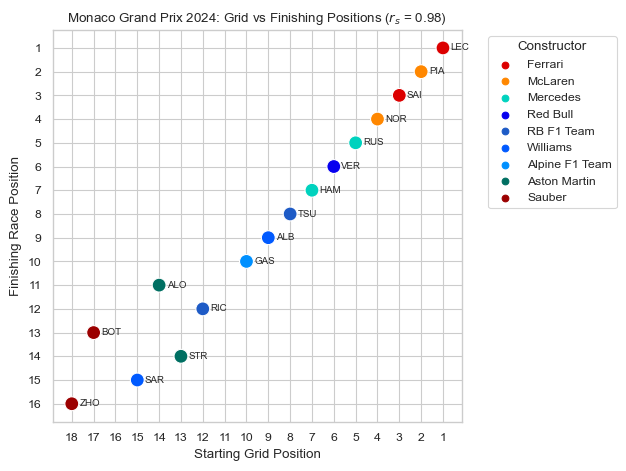

Spearman correlation between grid position and finishing position: 0.74


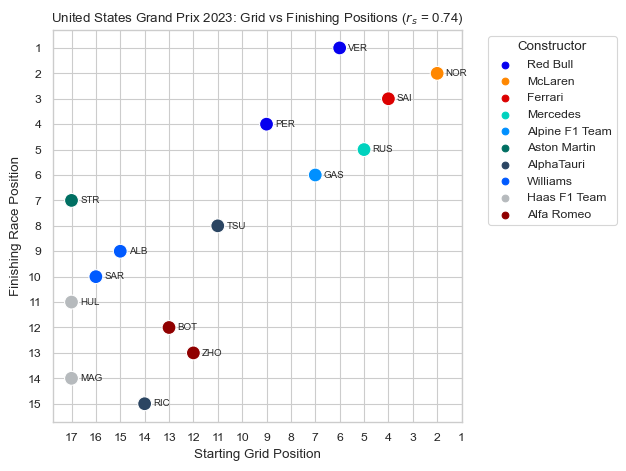

In [8]:
# High Rs example
plotRs(2024, 'Monaco Grand Prix')

# Low Rs example
plotRs(2023, 'United States Grand Prix')

In [9]:
def plotPosD(year, raceName):

    raceId = getRaceId(year, raceName)
    gridVsFinish = results[results['raceId'] == raceId].copy()
    gridVsFinish = lookupCols(gridVsFinish, drivers, 'driverId', ['code'])
    gridVsFinish = lookupCols(gridVsFinish, constructors, 'constructorId', ['name'])

    # Starts from pit lane are recorded as grid=0. Replace 0 with max grid + 1
    gridVsFinish['gridClean'] = gridVsFinish['grid'].replace(0, gridVsFinish['grid'].max() + 1)

    # Calculate grid position changes
    gridVsFinish['positionChange'] = gridVsFinish['gridClean'] - gridVsFinish['positionOrder']
    gridVsFinishSorted = gridVsFinish.sort_values('positionChange')

    ax = sns.barplot(
        data=gridVsFinishSorted, 
        x='positionChange', 
        y='code', 
        hue='name', 
        palette=constructor_palette, 
        dodge=False
    )

    ax.set_xlabel('Grid Position Change')
    ax.set_ylabel('Driver')
    ax.set_title(f'{raceName} {year}: Grid Position Changes')
    ax.invert_yaxis()
    ax.set_xticks(range(int(gridVsFinish['positionChange'].min()) - 1, int(gridVsFinish['positionChange'].max()) + 2, 2))
    ax.axvline(x=0, color='black', linestyle='-', linewidth=0.8)
    plt.legend(title='Constructor', bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()
    plt.show()

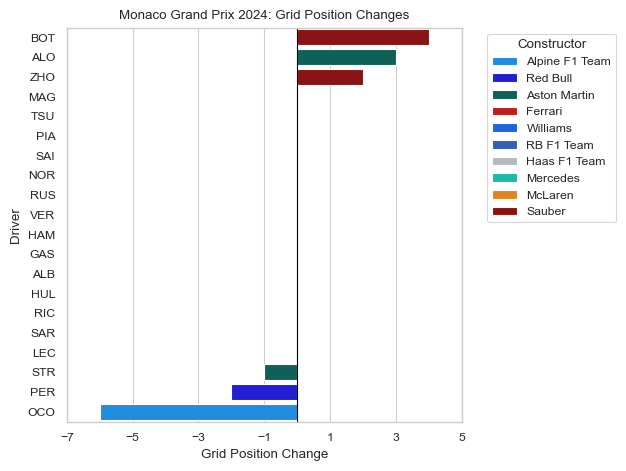

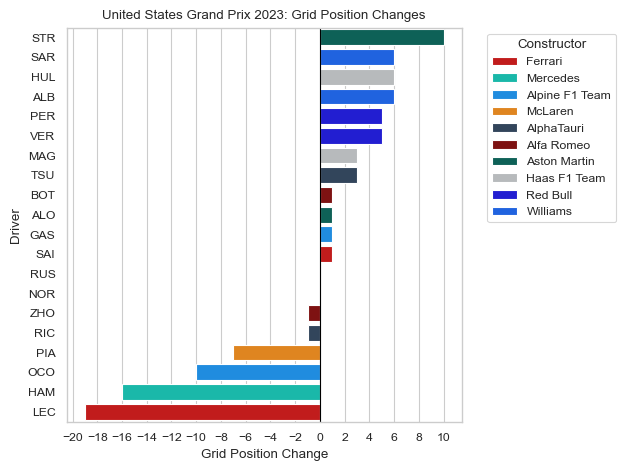

In [10]:
plotPosD(2024, 'Monaco Grand Prix')
plotPosD(2023, 'United States Grand Prix')

In [11]:
minYear, maxYear = 2022, 2024

resultsYear = lookupCols(results, races, 'raceId', ['year'])
resultsRegs = filterYears(resultsYear, minYear, maxYear)

# Starts from pit lane are recorded as grid=0. Replace 0 with max grid + 1
resultsRegs['gridClean'] = resultsRegs.groupby('raceId')['grid'].transform(
    lambda x: x.replace(0, x.max() + 1)
)

# Exclude retirements for rs calculation (Keep for position change)
resultsRegsFinishers = resultsRegs[resultsRegs['positionText'].str.isnumeric()]

C:\Users\benso\AppData\Local\Temp\ipykernel_26860\781244921.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  resultsRegs['gridClean'] = resultsRegs.groupby('raceId')['grid'].transform(


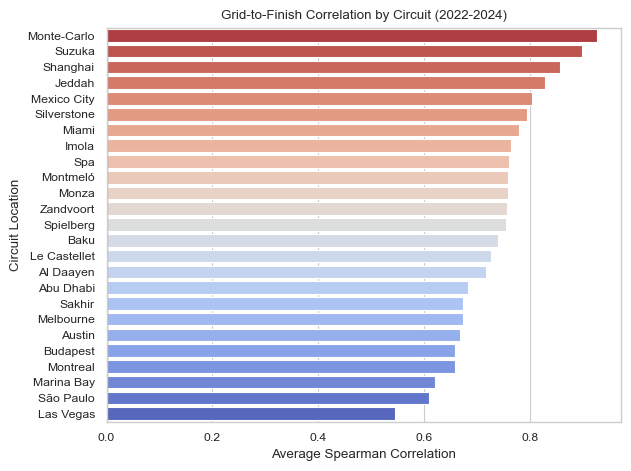

In [12]:
corrByRace = (
    resultsRegsFinishers
    .groupby('raceId')
    .apply(lambda x: stats.spearmanr(x['gridClean'], x['positionOrder'])[0] if len(x) > 2 else None)
    .rename('correlation') 
    .reset_index()
)

corrByRace = lookupCols(corrByRace, races, 'raceId', ['circuitId', 'year'])
corrByRace = lookupCols(corrByRace, circuits, 'circuitId', ['location'])

corrByCircuit = corrByRace.groupby('location')['correlation'].mean().reset_index()
corrByCircuit = corrByCircuit.sort_values('correlation', ascending=False)

ax = sns.barplot(
    data=corrByCircuit,
    x='correlation',
    y='location',
    palette='coolwarm_r'
)

ax.set_xlabel('Average Spearman Correlation')
ax.set_ylabel('Circuit Location')
ax.set_title(f'Grid-to-Finish Correlation by Circuit ({minYear}-{maxYear})')
ax.axvline(x=0, color='black', linestyle='-', linewidth=0.8)

plt.tight_layout()
plt.show()

C:\Users\benso\AppData\Local\Temp\ipykernel_26860\638332944.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  resultsRegs['positionChange'] = (


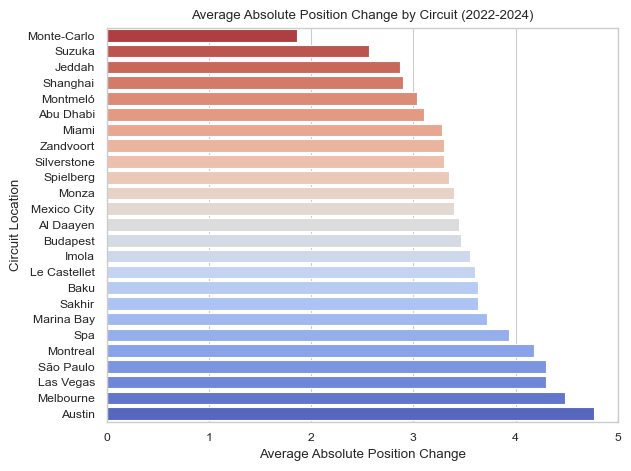

In [13]:
resultsRegs['positionChange'] = (
    resultsRegs['gridClean'] - resultsRegs['positionOrder']
).abs()

posDByRace = (
    resultsRegs
    .groupby('raceId')['positionChange']
    .mean()
    .reset_index()
)

posDByRace = lookupCols(posDByRace, races, 'raceId', ['circuitId', 'year'])
posDByRace = lookupCols(posDByRace, circuits, 'circuitId', ['location'])

posDByCircuit = (
    posDByRace
    .groupby('location')['positionChange']
    .mean()
    .reset_index()
    .sort_values('positionChange', ascending=False)
)

ax = sns.barplot(
    data=posDByCircuit,
    x='positionChange',
    y='location',
    palette='coolwarm'
)

ax.set_xlabel('Average Absolute Position Change')
ax.set_ylabel('Circuit Location')
ax.set_title(f'Average Absolute Position Change by Circuit ({minYear}-{maxYear})')

ax.invert_yaxis()

plt.tight_layout()
plt.show()

C:\Users\benso\AppData\Local\Temp\ipykernel_26860\4186794776.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  resultsRegs['positionChange'] = (


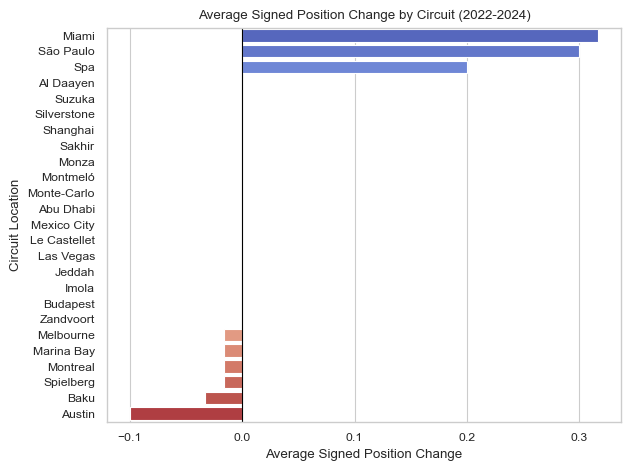

In [14]:
resultsRegs['positionChange'] = (
    resultsRegs['gridClean'] - resultsRegs['positionOrder']
)

posDByRace = (
    resultsRegs
    .groupby('raceId')['positionChange']
    .mean()
    .reset_index()
)

posDByRace = lookupCols(posDByRace, races, 'raceId', ['circuitId', 'year'])
posDByRace = lookupCols(posDByRace, circuits, 'circuitId', ['location'])

posDByCircuit = (
    posDByRace
    .groupby('location')['positionChange']
    .mean()
    .reset_index()
    .sort_values('positionChange', ascending=False)
)

ax = sns.barplot(
    data=posDByCircuit,
    x='positionChange',
    y='location',
    palette='coolwarm'
)

ax.set_xlabel('Average Signed Position Change')
ax.set_ylabel('Circuit Location')
ax.set_title(f'Average Signed Position Change by Circuit ({minYear}-{maxYear})')
ax.axvline(x=0, color='black', linestyle='-', linewidth=0.8)

plt.tight_layout()
plt.show()